# Corrosion Environmental Features <3
This notebook corresponds to the cleaning and analyzing the features associated with corrosion, features that are due to the enviroment in which the corrosion is tested.
* 1. Features are cleaned
* 2. Exploratory analysis is made to understand the features
* 3. Test Temperature and pH are inputated using:SimpleImputation,
        NN_inmputation, Interpolation inputation 
* 4. Simple lr understand the difference
* 5. Hot encoding is done for Materials Classes
* 6. A new dataframe is converted into csv to concatenate this data with the features corresponding to material composition.


Nyby, C., Guo, X., Saal, J.E. et al. Electrochemical metrics for corrosion resistant alloys. Sci Data 8, 58 (2021). https://doi.org/10.1038/s41597-021-00840-y


In [47]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib also got problems and i should reinstall it
import seaborn as sns
from scipy import stats

import plotly.express as px
import plotly.graph_objects as go
#I have problems with plotly it was working fine but suddenly it required to deinstall and reinstall
import warnings
import mlflow

from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import time
import scipy.cluster.hierarchy as sch
from sklearn.neighbors import NearestNeighbors

# Models making
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# import to create polynomial features
from sklearn.preprocessing import PolynomialFeatures
# import of the linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,  mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

warnings.filterwarnings('ignore')
# Specifing figure layout
'''
plt.style.use('fivethirtyeight')
sns.set_color_codes('bright')
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
plt.rcParams["figure.figsize"] = (15, 10)

'''

'\nplt.style.use(\'fivethirtyeight\')\nsns.set_color_codes(\'bright\')\nplot_kwds = {\'alpha\' : 0.25, \'s\' : 80, \'linewidths\':0}\nplt.rcParams["figure.figsize"] = (15, 10)\n\n'

In [48]:
from tabulate import tabulate
from sklearn.preprocessing import OneHotEncoder

### 1. Features Cleaning

In [49]:
data_all = pd.read_excel("../data/Epit.xlsx")

In [50]:
data_all.columns

Index(['No.', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn', 'Cu',
       'P', 'S', 'Al', 'V', 'Ta', 'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd',
       'Avg Epit. mV (SCE)', 'Epit. mV (SCE) Max', 'Min Epit. mV (SCE)',
       'Test Temp °C', 'Test Solution', '[Cl-]', 'pH', 'Test Method',
       'Scan Rate (mV/s)', 'Heat treatment', 'Microstructures', 'Comments',
       'Reference', 'Material class'],
      dtype='object')

In [51]:
#Lets just simplify the names and take the spaces out:
data_all.columns= ['No.', 'Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn', 'Cu',
       'P', 'S', 'Al', 'V', 'Ta', 'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd',
       'Epit', 'Epit_Max', 'Epit_Min', 'Test_Temp', 'Test_Solution', 'Cl', 'pH', 'Method',
       'Sc_rate', 'Heat_treatment', 'Microstr', 'Comments',
       'Ref', 'Material']

In [52]:
data_all.head()

,No.,Fe,Cr,Ni,Mo,W,N,Nb,C,Si,...,Test_Solution,Cl,pH,Method,Sc_rate,Heat_treatment,Microstr,Comments,Ref,Material
0,1,69.705,18.0,10.0,NaN,0.0,0.0,0.0,0.03,1.0,...,"300 ppm NaCl, pH 7.8",0.005133,7.8,Potentiodynamic Polarization with exposed area...,0.1,None,NaN,S30403 (304L),49,Fe Alloy
1,2,69.705,18.0,10.0,NaN,0.0,0.0,0.0,0.03,1.0,...,"500 ppm NaCl, pH 7.8",0.008556,7.8,Potentiodynamic Polarization with exposed area...,0.1,None,NaN,S30403 (304L),49,Fe Alloy
2,3,69.705,18.0,10.0,NaN,0.0,0.0,0.0,0.03,1.0,...,"1000 ppm NaCl, pH 7.8",0.017112,7.8,Potentiodynamic Polarization with exposed area...,0.1,None,NaN,S30403 (304L),49,Fe Alloy
3,4,69.705,18.0,10.0,NaN,0.0,0.0,0.0,0.03,1.0,...,"5000 ppm NaCl, pH 7.8",0.085558,7.8,Potentiodynamic Polarization with exposed area...,0.1,None,NaN,S30403 (304L),49,Fe Alloy
4,5,69.705,18.0,10.0,NaN,0.0,NaN,0.0,0.03,1.0,...,Seawater Natural,0.546000,8.2,Potentiodynamic Polarization with exposed area...,0.1,None,NaN,S30403 (304L),49,Fe Alloy


In [53]:
#Lets drop the columns already made on the Metal_Feature notebook
Data_Medio= data_all.drop(['Fe', 'Cr', 'Ni', 'Mo', 'W', 'N', 'Nb', 'C', 'Si', 'Mn', 'Cu',
       'P', 'S', 'Al', 'V', 'Ta', 'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd'], axis=1)

In [54]:
print(Data_Medio.columns)
# From this features we discard Epit_Max and Min because they present too many missing, but i would be possible to guess the values with the other features taken into account. However for this study they will be discard.

Index(['No.', 'Epit', 'Epit_Max', 'Epit_Min', 'Test_Temp', 'Test_Solution',
       'Cl', 'pH', 'Method', 'Sc_rate', 'Heat_treatment', 'Microstr',
       'Comments', 'Ref', 'Material'],
      dtype='object')


In [55]:
print("Features that are possible to be use :")
print("Test_Temp in °C :",(Data_Medio["Test_Temp"].nunique()))
print("Conc of Cl :", (Data_Medio["Cl"].nunique()))
print("pH :", (Data_Medio["pH"].nunique()))
print("Sc_rate :", (Data_Medio["Sc_rate"].nunique()))
print("Comments :", (Data_Medio["Comments"].nunique()))
print("References Cited :", (Data_Medio["Ref"].nunique()))

Features that are possible to be use :
Test_Temp in °C : 22
Conc of Cl : 29
pH : 26
Sc_rate : 28
Comments : 83
References Cited : 67


### Variables that would need Target Encoding

In [56]:
print("Features too complex but should be taken into account :")
print("Classes of Microstructures :",(data_all["Microstr"].nunique()))
print("Types of Test_Solution :", (data_all["Test_Solution"].nunique()))
print("Methods of Heat_treatment :", (data_all["Heat_treatment"].nunique()))
print("Type of Method Use :", (data_all["Method"].nunique()))
print("Current density Scan rate :", (data_all["Sc_rate"].nunique()))
print("Comments :", (data_all["Comments"].nunique())) 

Features too complex but should be taken into account :
Classes of Microstructures : 43
Types of Test_Solution : 115
Methods of Heat_treatment : 80
Type of Method Use : 51
Current density Scan rate : 28
Comments : 83


### Final features to take into account

In [57]:
#Final features to take into account
Data_Medio_net=Data_Medio.drop(['Epit_Max', 'Epit_Min',  'Test_Solution', 'Method', 'Sc_rate', 'Heat_treatment', 'Microstr', 'Comments', 'Ref'], axis=1)
print("Features to be considered as Medium of the Corrosion Test :", Data_Medio_net.columns )

Features to be considered as Medium of the Corrosion Test : Index(['No.', 'Epit', 'Test_Temp', 'Cl', 'pH', 'Material'], dtype='object')


In [58]:
Data_Medio_net.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   No.        810 non-null    int64  
 1   Epit       801 non-null    object 
 2   Test_Temp  727 non-null    float64
 3   Cl         810 non-null    float64
 4   pH         762 non-null    float64
 5   Material   810 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 38.1+ KB


### Target Cleaning 

In [59]:
# Our target value is Epit, we need Changing the Target value from data type object to float
from cmath import nan

Data_Medio_net["Epit"]=Data_Medio_net["Epit"].replace(">800", 801)
Data_Medio_net["Epit"]=Data_Medio_net["Epit"].replace(">1256", 1257)
#there is an unexpected simbol in the target value, i will replace it to NAN and then I will drop all rows with NAN in that column
Data_Medio_net["Epit"].replace("Transpassive", np.nan, inplace=True)
#Change the type from object to float on Epit
Data_Medio_net = Data_Medio_net.astype({"Epit": float})
# delete all the values of Epit that are NaNs
Data_Medio_netT= Data_Medio_net.dropna(how="any", subset=["Epit"])
# resetting the DataFrame index
Data_Medio_netT= Data_Medio_netT.reset_index()
print("Epit NaNs :", Data_Medio_netT["Epit"].isna().sum())
print("Epit values :", Data_Medio_netT["Epit"].nunique())
print("Data_Medio_netT shape :", Data_Medio_netT.shape)
print("Features :", Data_Medio_netT.info())
Data_Medio_netT.tail()

Epit NaNs : 0
Epit values : 573
Data_Medio_netT shape : (760, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      760 non-null    int64  
 1   No.        760 non-null    int64  
 2   Epit       760 non-null    float64
 3   Test_Temp  677 non-null    float64
 4   Cl         760 non-null    float64
 5   pH         712 non-null    float64
 6   Material   760 non-null    object 
dtypes: float64(4), int64(2), object(1)
memory usage: 41.7+ KB
Features : None


,index,No.,Epit,Test_Temp,Cl,pH,Material
755,805,810,-244.0,25.0,0.1,7.0,Al Alloy
756,806,811,-744.0,25.0,0.5,7.0,Al Alloy
757,807,812,-654.0,25.0,0.1,7.0,Al Alloy
758,808,813,-694.0,25.0,0.1,7.0,Al Alloy
759,809,814,-684.0,25.0,0.1,7.0,Al Alloy


In [60]:
# We need to know the percentage of NaNs values in every column
na_percentage = Data_Medio_netT.isna().sum()/Data_Medio_netT.shape[0]*100
na_percentage

index         0.000000
No.           0.000000
Epit          0.000000
Test_Temp    10.921053
Cl            0.000000
pH            6.315789
Material      0.000000
dtype: float64

In [61]:
#Rounding Cloride
Data_Medio_netT.Cl=Data_Medio_netT.Cl.round(2)

In [62]:
Data_Medio_netT.head()

,index,No.,Epit,Test_Temp,Cl,pH,Material
0,0,1,287.0,50.0,0.01,7.8,Fe Alloy
1,1,2,260.0,50.0,0.01,7.8,Fe Alloy
2,2,3,218.0,50.0,0.02,7.8,Fe Alloy
3,3,4,140.0,50.0,0.09,7.8,Fe Alloy
4,4,5,94.0,50.0,0.55,8.2,Fe Alloy


### Imputing Values for Test Temp and pH
You can try to impute the values using Nearest Neighbours and interpolation, let see how is different.

In [63]:
#imputing values for Test_Temp and Chloride which should be independent of the type of material
Temp_pH_i= Data_Medio_netT[['Test_Temp', 'pH']].interpolate(method="linear")
Temp_pH_i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Test_Temp  760 non-null    float64
 1   pH         760 non-null    float64
dtypes: float64(2)
memory usage: 12.0 KB


In [64]:
from sklearn.impute import KNNImputer
nan = np.nan

imputer = KNNImputer(n_neighbors=2, weights="uniform")
Temp_pH_NN= imputer.fit_transform(Data_Medio_netT[['Test_Temp', 'pH']])
Temp_pH_NNdf= pd.DataFrame(Temp_pH_NN)
Temp_pH_NNdf.columns=['Test_Temp', 'pH']
Temp_pH_NNdf.tail()

,Test_Temp,pH
755,25.0,7.0
756,25.0,7.0
757,25.0,7.0
758,25.0,7.0
759,25.0,7.0


In [65]:
print(f"Data_Medio_netT :", Data_Medio_netT.columns)

Data_Medio_netT : Index(['index', 'No.', 'Epit', 'Test_Temp', 'Cl', 'pH', 'Material'], dtype='object')


Two different DataFrame are created. Test Temp and pH was compared with different inputations

In [66]:
Test_Temp_df =pd.concat([Data_Medio_netT[['Epit', 'Test_Temp', 'Cl', 'Material']], Temp_pH_i[["Test_Temp"]], Temp_pH_NNdf[["Test_Temp"]]], axis=1)
Test_Temp_df.columns=["Epit", "Test_Temp", "Cl", "Material", "Test_Temp_i", "Test_Temp_NN"]

In [67]:
pH_df =pd.concat([Data_Medio_netT[['Epit', 'Cl', 'pH', 'Material']], Temp_pH_i[["pH"]], Temp_pH_NNdf[["pH"]]], axis=1)
pH_df.columns=['Epit', 'Cl', 'pH', 'Material', 'pH_i', 'pH_NN']

In [68]:
Data_Medio_netT["Material"].unique()

array(['Fe Alloy', 'Other', 'HEA', 'NiCrMo Alloy', 'Al Alloy'],
      dtype=object)

In [69]:
Data_Medio_netT= Data_Medio_netT.drop(["No."], axis=1)

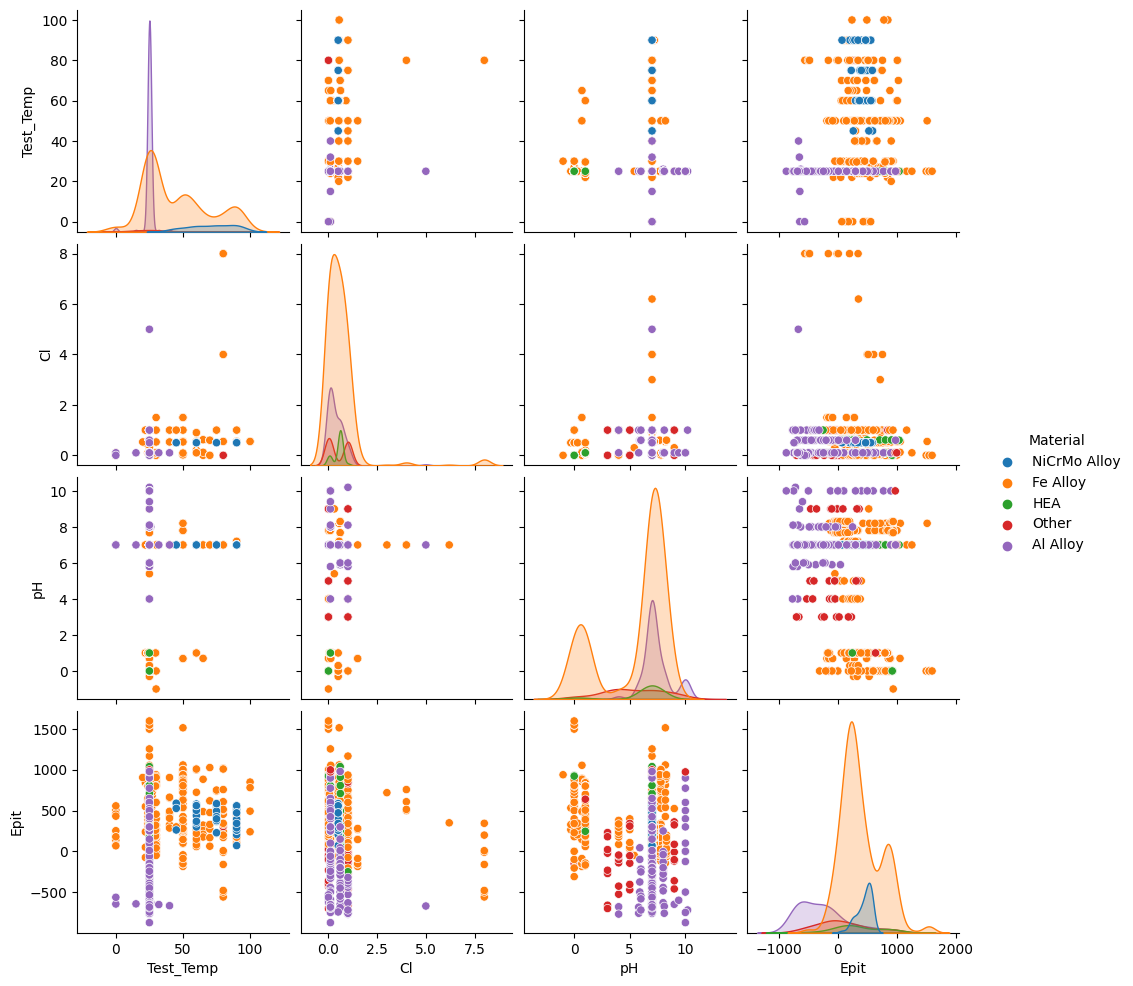

In [70]:
sns.pairplot(data=Data_Medio_netT[['Test_Temp', 'Cl', 'pH', 'Material', 'Epit']],
              hue='Material',
              hue_order=['NiCrMo Alloy','Fe Alloy','HEA','Other','Al Alloy'])

Correlations are not visually understandable, we muss model the features to try the different methods

Interesting to search for differences due to method, however it should not be any significant difference and would bring nothing really more than a critical commentary on this respect. Therefore, this information would be excluded from the present study

In [71]:
#I liked better the imputation by interpolation so the final matriz would be involving just that data
Corr_Finali =pd.concat([Data_Medio_netT[['Epit', 'Cl', 'Material']], Temp_pH_i[["Test_Temp", "pH"]]], axis=1)
Corr_Finali.columns=['Epit', 'Cl', 'Material',  "Test_Temp", "pH"]

## Corrosion for pitting depending on class of Material

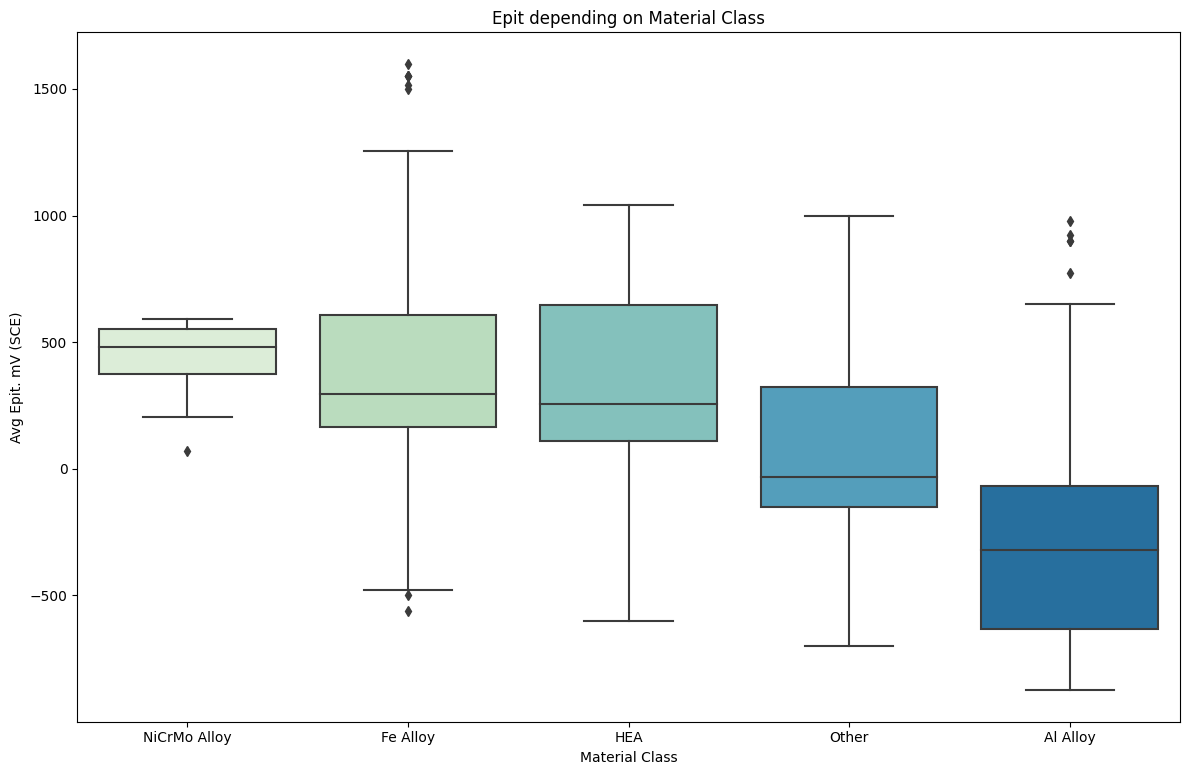

In [72]:
fig, (ax1) = plt.subplots(1, figsize=(12, 8))
plt.suptitle('')

plot1 = sns.boxplot(data=Corr_Finali, x='Material', y='Epit', ax=ax1, palette="GnBu", order=['NiCrMo Alloy','Fe Alloy', 'HEA','Other', 'Al Alloy'])
ax1.set_title('Epit depending on Material Class')
ax1.set_ylabel('Avg Epit. mV (SCE)')
ax1.set_xlabel('Material Class')

plt.tight_layout();

###  Variables that would need Hot Encoding 
relevant metadata from strings features to numerical data, so that I could use in all the models

## Hot encoding for discrete values of Material Classes

In [73]:
Corr_Finali['Material'].unique()

array(['Fe Alloy', 'Other', 'HEA', 'NiCrMo Alloy', 'Al Alloy'],
      dtype=object)

In [74]:
#dummy-encode the Material Class feature
Material = pd.get_dummies(Corr_Finali['Material'], prefix='M',drop_first=False)
Material.columns

Index(['M_Al Alloy', 'M_Fe Alloy', 'M_HEA', 'M_NiCrMo Alloy', 'M_Other'], dtype='object')

In [75]:
Material.columns=["M_Al", "M_Fe", "M_HEA", "M_NiCrMo", "M_Other"]
#Converting the new columns to floats types
Material= Material.astype({"M_Al": float})
Material= Material.astype({"M_Fe": float})
Material= Material.astype({"M_HEA": float})
Material= Material.astype({"M_NiCrMo": float})
Material= Material.astype({"M_Other": float})
Material.tail()

,M_Al,M_Fe,M_HEA,M_NiCrMo,M_Other
755,1.0,0.0,0.0,0.0,0.0
756,1.0,0.0,0.0,0.0,0.0
757,1.0,0.0,0.0,0.0,0.0
758,1.0,0.0,0.0,0.0,0.0
759,1.0,0.0,0.0,0.0,0.0


In [76]:
# concatenate dummy-encoded locations feature to original dataframe
Corr_Finali_A = pd.concat([Corr_Finali, Material],axis = 1)
print(f"Corrosion Final Medio inputed with alloys Columns and Shape:", Corr_Finali_A.columns, Corr_Finali_A.shape) 

Corrosion Final Medio inputed with alloys Columns and Shape: Index(['Epit', 'Cl', 'Material', 'Test_Temp', 'pH', 'M_Al', 'M_Fe', 'M_HEA',
       'M_NiCrMo', 'M_Other'],
      dtype='object') (760, 10)


In [77]:
Corr_Finali_A= Corr_Finali_A.drop("Material", axis=1)

In [78]:
Corr_Finali_A.to_csv("../data/Corrosion_Finalia.csv", index=False)

In [79]:
Corr_Finali_A.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Epit       760 non-null    float64
 1   Cl         760 non-null    float64
 2   Test_Temp  760 non-null    float64
 3   pH         760 non-null    float64
 4   M_Al       760 non-null    float64
 5   M_Fe       760 non-null    float64
 6   M_HEA      760 non-null    float64
 7   M_NiCrMo   760 non-null    float64
 8   M_Other    760 non-null    float64
dtypes: float64(9)
memory usage: 53.6 KB


### Modelling the Features to understand the imputations done

In [80]:
print("Features Corr_Finali_A .", Corr_Finali_A.columns)

Features Corr_Finali_A . Index(['Epit', 'Cl', 'Test_Temp', 'pH', 'M_Al', 'M_Fe', 'M_HEA', 'M_NiCrMo',
       'M_Other'],
      dtype='object')


In [81]:
Corr_Finali_A.head()

,Epit,Cl,Test_Temp,pH,M_Al,M_Fe,M_HEA,M_NiCrMo,M_Other
0,287.0,0.01,50.0,7.8,0.0,1.0,0.0,0.0,0.0
1,260.0,0.01,50.0,7.8,0.0,1.0,0.0,0.0,0.0
2,218.0,0.02,50.0,7.8,0.0,1.0,0.0,0.0,0.0
3,140.0,0.09,50.0,7.8,0.0,1.0,0.0,0.0,0.0
4,94.0,0.55,50.0,8.2,0.0,1.0,0.0,0.0,0.0


In [82]:
#Selecting X and y variables
X=Corr_Finali_A.drop(["Epit"] , axis=1)
y=Corr_Finali_A.Epit
#Creating a Simple Linear Regression Model 
lm=LinearRegression()
lm.fit(X,y)
#Prediction 
yp=lm.predict(X)

In [83]:
#Metrics
print("MAE in Test Multi_LR Interinputer", "-->", round(mean_absolute_error(y, yp),2))
print("RMSE in Test Multi_LR Interinputer", "-->", round(mean_squared_error(y, yp, squared=False),2))
print("RMSE/MAE :", round((mean_squared_error(y, yp, squared=False))/(mean_absolute_error(y, yp)),2))
print("R2 for Multi_LR Interinputer", "-->", round(r2_score(y, yp), 2))


MAE in Test Multi_LR Interinputer --> 267.09
RMSE in Test Multi_LR Interinputer --> 342.11
RMSE/MAE : 1.28
R2 for Multi_LR Interinputer --> 0.36


In [84]:
Data_Medio_netT.tail()
#Data_Medio_netT.shape

,index,Epit,Test_Temp,Cl,pH,Material
755,805,-244.0,25.0,0.1,7.0,Al Alloy
756,806,-744.0,25.0,0.5,7.0,Al Alloy
757,807,-654.0,25.0,0.1,7.0,Al Alloy
758,808,-694.0,25.0,0.1,7.0,Al Alloy
759,809,-684.0,25.0,0.1,7.0,Al Alloy


In [85]:
Data_Medio_netT.shape
#Temp_pH_NNdf.tail()
#Material.shape


(760, 6)

In [86]:
Material.tail()

,M_Al,M_Fe,M_HEA,M_NiCrMo,M_Other
755,1.0,0.0,0.0,0.0,0.0
756,1.0,0.0,0.0,0.0,0.0
757,1.0,0.0,0.0,0.0,0.0
758,1.0,0.0,0.0,0.0,0.0
759,1.0,0.0,0.0,0.0,0.0


Joining the imputation features by interpolation NN with the material after hotencoding :see_no_evil:

In [87]:
Impu_Temp_pH= pd.concat([Temp_pH_NNdf, Material, Data_Medio_netT[['Epit', 'Cl']]], axis=1)
Impu_Temp_pH.shape

(760, 9)

In [88]:
#Selecting X and y variables
Xnn=Impu_Temp_pH.drop("Epit", axis=1)
ynn=Impu_Temp_pH.Epit
#Creating a Simple Linear Regression Model to predict Epit
lmnn=LinearRegression()
lmnn.fit(Xnn,ynn)
#Prediction of Epit NN
ypnn=lmnn.predict(Xnn)
#Metrics
print("MAE in Test Multi_LR NNinputer", "-->", round(mean_absolute_error(ynn, ypnn),2))
print("RMSE in Test Multi_LR NNinputer", "-->", round(mean_squared_error(ynn, ypnn, squared=False),2))
print("RMSE/MAE :", round((mean_squared_error(ynn, ypnn, squared=False))/(mean_absolute_error(ynn, ypnn)),2))
print("R2 for Multi_LR NNinputer", "-->", round(r2_score(ynn, ypnn), 2))

MAE in Test Multi_LR NNinputer --> 272.42
RMSE in Test Multi_LR NNinputer --> 344.78
RMSE/MAE : 1.27
R2 for Multi_LR NNinputer --> 0.35


Thus, overall we can interpret that 0.35% of the model predictions are correct and the variation in the errors is around 65 units. For an ideal model, RMSE/MAE=0 and R2 score = 1, RMSE/MAE 

In conclusion it is the same numerically, a 0.01 much better the interpolation but no more <3 ;)

# :blush:
 Seeing difference grapycally


In [89]:
Corr_Finali_A.columns

Index(['Epit', 'Cl', 'Test_Temp', 'pH', 'M_Al', 'M_Fe', 'M_HEA', 'M_NiCrMo',
       'M_Other'],
      dtype='object')

How Chloride attack different Materials ?
x= Cloride and y= Epit for each class

<AxesSubplot:xlabel='Cl', ylabel='Epit'>

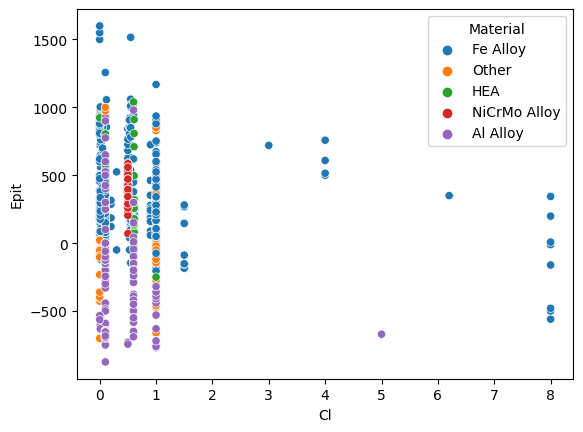

In [90]:
sns.scatterplot(data = Corr_Finali, x = Corr_Finali.Cl, y = Corr_Finali_A.Epit, hue = "Material")

It is pH same as Cl attack different Materials ?
x= pH and y= Epit for each class

<AxesSubplot:xlabel='pH', ylabel='Epit'>

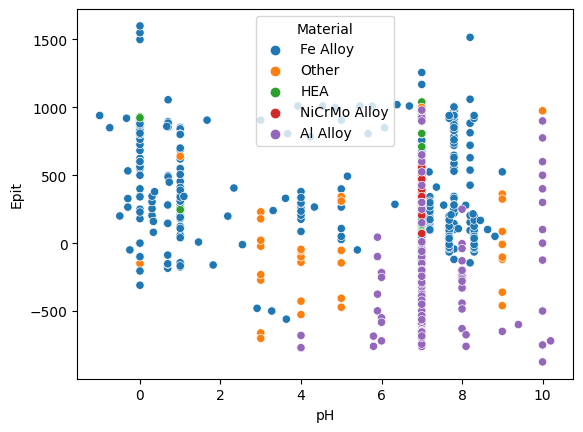

In [91]:
sns.scatterplot(data = Corr_Finali, x = Corr_Finali.pH, y = Corr_Finali_A.Epit, hue = "Material")

As we can see, the chloride tell us that at high Cl conc the Fe Alloys are more compromised and therefore it takes less Electric Potential to brake/pit the material.
In the case of pH, the scenario is different and it is no possible to see clear patterns. The Fe Alloys will corrode at any pH and the Aluminium brakes preferentially at high pH as well as the NiCrMo alloys. 